<a href="https://colab.research.google.com/github/SeongwonTak/TIL_swtak/blob/master/DataScience/210127_Feture_selection%2C_extraction_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#210126~210127 Feature selection and extraction 2

결국 어제, 풀밭이 여러 일들이 많아 끊기고 말았다... 젠장.

어제에 이어 PCA에 대해 공부한다.
PCA의 알고리즘과 주요 부분의 밑바닥 코딩 내용에 대해 확인한다.
오늘 일이 있어..많은 내용은 보지 못했다.

## 1. PCA 알고리즘의 개요.

다음 순서대로 PCA 알고리즘을 진행한다.

- 1. data를 표준화 한다.
- 2. covariance matrix를 계산한다. (공분산 행렬)
- 3. covariance matrix의 eigenvector, eigenvalue를 계산한다.
- 4. eigenvalue들을 내림차순으로 정렬 후, 목표하는 k차원에 맞게, 상위 k개의 eigenvalue에 해당하는 eigenvector들을 선택한다.
- 5. 해당하는 eigenvector들을 행으로 하여 Projection Matrix $W$를 만든다.
- 6. $xW$ 를 만들면 Profit!

이 알고리즘 과정에 대해 이해를 해보고 일부 부분을 직접 구현하면서 보고자 한다.


## 2. PCA의 이해

우선 가장 먼저, 이해해야 하는 것은 covariance matrix가 무엇인가? 이다.

공분산 행렬은 모든 샘플별로 공분산을 계산하여 나열한 것이다.
$$ 
\begin{pmatrix}
\sigma_{1}^{2} & \sigma_{12} & \sigma_{13} ... \\
\sigma_{21} & \sigma_{2}^{2} & \sigma_{23} ...\\
\sigma_{31} & \sigma_{32} & \sigma_{3}^{2} ...\\
... & ... & ...
\end{pmatrix}$$

이 행렬의 고유벡터가 주성분의 방향을 표현하며 고윳값이 주성분의 
크기를 표현한다. 고유벡터가 주축의 위치를 표현한다는 것을 생각해보면 자연스러운 현상이다.



In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
X = wine.iloc[:, 1:].values
y = wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify = y,
                                                    random_state=0)
sc = StandardScaler()  # 다시말하지만, PCA는 스케일링이 필수이다.
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)


#고윳값의 출력
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print(eigen_vals)


# 고유값, 고유벡터 튜플 정리
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key = lambda k:k[0], reverse = True)


# 열로 eigenvector들을 묶어 투영행렬을 만들려고 한다.
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis],
               eigen_pairs[2][1][:, np.newaxis]))
print(w)

[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]
[[-0.13724218  0.50303478 -0.13774873]
 [ 0.24724326  0.16487119  0.09615039]
 [-0.02545159  0.24456476  0.67777567]
 [ 0.20694508 -0.11352904  0.62504055]
 [-0.15436582  0.28974518  0.19613548]
 [-0.39376952  0.05080104  0.14031057]
 [-0.41735106 -0.02287338  0.11705386]
 [ 0.30572896  0.09048885  0.13121778]
 [-0.30668347  0.00835233  0.0304309 ]
 [ 0.07554066  0.54977581 -0.07992997]
 [-0.32613263 -0.20716433  0.05305915]
 [-0.36861022 -0.24902536  0.13239103]
 [-0.29669651  0.38022942 -0.07065022]]


## 3. PCA with scikit-learn
sklearn을 통하여 PCA의 사용법에 대해 학습해보자.


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
principalComponents = pca.fit_transform(X_test_std)
principalDf = pd.DataFrame(data = principalComponents, columns=['cp1', 'cp2', 'cp3', 'cp4', 'cp5'])
principalDf

PCA에서 대체 몇개의 주성분을 골라야 하는가?
주성분 각각의 고윳값을, 고윳값들을 모두 더한 값으로 나눠 주고 더해본다.

In [14]:
sum(pca.explained_variance_ratio_)

0.829615861448753

주성분 5개로 전체 분산의 82%를 설명하게 된다.

이제 2개의 주성분을 기반으로 한 모델을 다시 만들고, 이를 기반으로 시각화를 해볼것이다.

이에는 Iris 데이터를 활용할려고 한다.

In [25]:
from sklearn.datasets import load_iris

iris = load_iris()

data = pd.DataFrame(iris.data, columns=iris.feature_names)
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [26]:
# 데이터 적용 전 standardSclaer 적용.
scaler = StandardScaler()
result = scaler.fit_transform(data)
scaled_data = pd.DataFrame(result, columns=iris.feature_names)

In [27]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(scaled_data)
result = pd.DataFrame(data = principalComponents, columns=['cp1', 'cp2'])
result

,cp1,cp2
0,-2.264703,0.480027
1,-2.080961,-0.674134
2,-2.364229,-0.341908
3,-2.299384,-0.597395
4,-2.389842,0.646835
...,...,...
145,1.870503,0.386966
146,1.564580,-0.896687
147,1.521170,0.269069
148,1.372788,1.011254


In [29]:
# 시각화를 위해서는 결과를 붙여야 한다.

target = pd.DataFrame(iris.target, columns=['type'])
target['type'] = target['type'].apply(lambda x: iris.target_names[x])
merged = pd.concat([result, target], axis=1)
merged

,cp1,cp2,type
0,-2.264703,0.480027,setosa
1,-2.080961,-0.674134,setosa
2,-2.364229,-0.341908,setosa
3,-2.299384,-0.597395,setosa
4,-2.389842,0.646835,setosa
...,...,...,...
145,1.870503,0.386966,virginica
146,1.564580,-0.896687,virginica
147,1.521170,0.269069,virginica
148,1.372788,1.011254,virginica


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


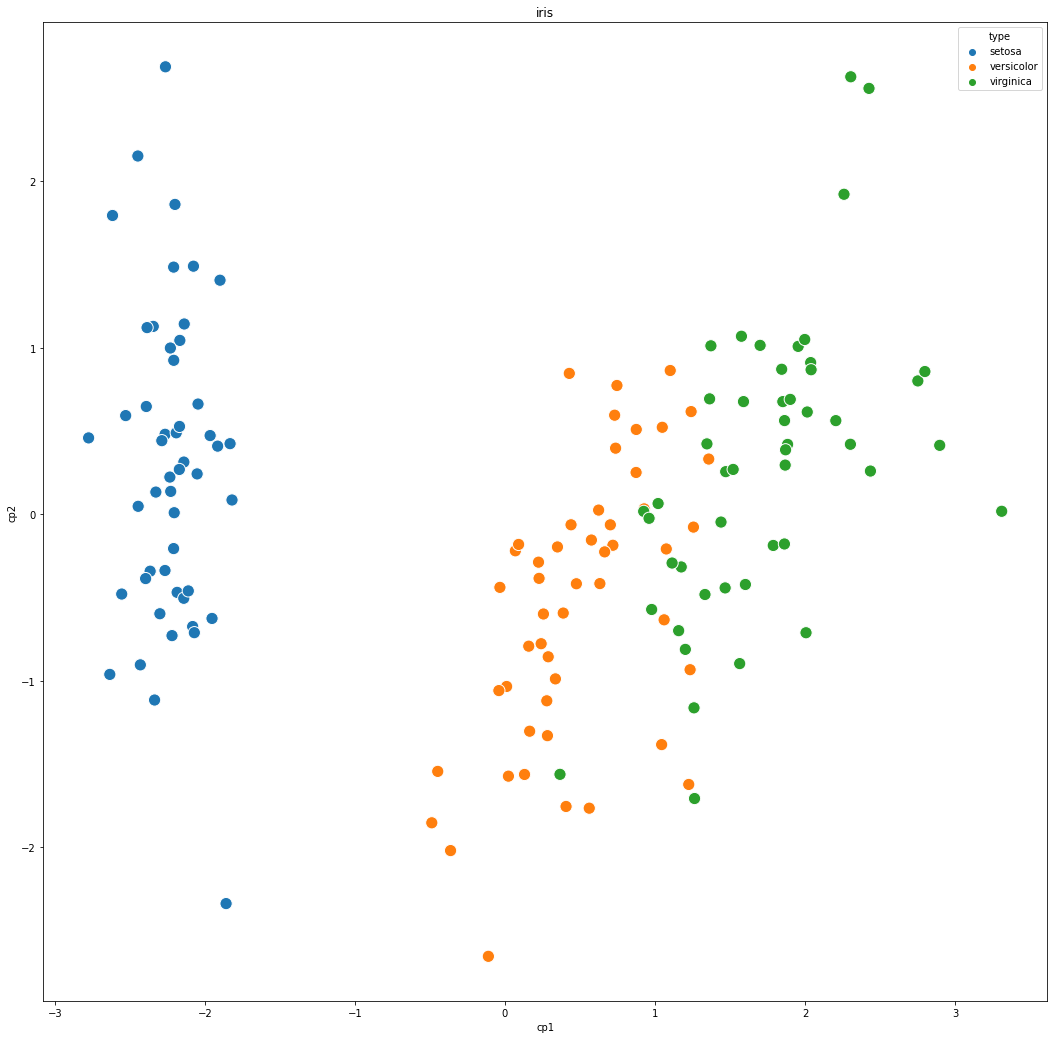

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,18))

sns.scatterplot(merged['cp1'], merged['cp2'],
                hue=merged['type'],
                s=150)
plt.title('iris')
plt.show()

In [ ]:
4개의 변수가 있는 iris임에도 불구하고 2차원 공간으로 잘 축소에 성공했다!